In [1]:
import glob
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [42]:
#@title NN parameters
IMG_SIZE = 224 #@param {type:"integer"}
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

SPLIT_WEIGHTS = (8, 1, 1)
BATCH_SIZE = 32 #@param {type:"integer"}
SHUFFLE_BUFFER_SIZE = 1000

drive_path = '/content/drive/MyDrive' #@param {type:"string"}

In [11]:
#@title Download and unpack dataset

!mkdir dataset
!unzip /content/drive/MyDrive/image_photo_classifier/dataset/photos.zip -d dataset
!unzip /content/drive/MyDrive/image_photo_classifier/dataset/other.zip -d dataset
!unzip /content/drive/MyDrive/image_photo_classifier/dataset/screenshots.zip -d dataset

clear_output()

In [44]:
#@title Load images data
    
def get_files_in_folder(path: str) -> list:
    return list(glob.glob(f'{path}/*.jpg'))

def read_image(image_path) -> list:
    target_size = (IMG_SIZE, IMG_SIZE)
    img = tf.keras.preprocessing.image.load_img(image_path, color_mode = "rgb", target_size=target_size)
    x = tf.keras.preprocessing.image.img_to_array(img)
    return x

# create dataset
x_photos = [read_image(x) for x in get_files_in_folder('dataset/photos')]
x_screens = [read_image(x) for x in get_files_in_folder('dataset/screenshots')]
x_others = [read_image(x) for x in get_files_in_folder('dataset/other')]

x_train = []
y_train = []
[(x_train.append(f), y_train.append(0)) for f in x_photos] # photo as photo
[(x_train.append(f), y_train.append(1)) for f in x_screens] # screen as image
[(x_train.append(f), y_train.append(1)) for f in x_others] # other images as image

x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)

print('Done')
print(f'Image shapes: {x_train.shape}')

done
image shapes:


(2266, 224, 224, 3)

In [45]:
#@title Create TensorFlow compatible dataset and free memory

train_x, test_x, train_y, test_y = train_test_split(x_train, y_train, test_size=0.20)
train_y = train_y.astype(np.float32)
test_y = test_y.astype(np.float32)

#free memory
del x_train, y_train

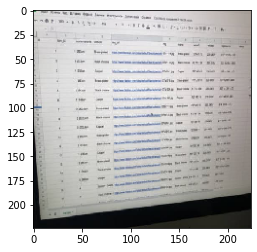

In [48]:
#@title Show random image from dataset

index = np.random.choice(len(test_x))
img = test_x[index]
img = img.reshape(IMG_SHAPE)

plt.imshow((img.reshape(IMG_SHAPE)).astype(np.uint8), vmin=0, vmax=255)
plt.show()

In [51]:
#@title MobileNetV2 model

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False)

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 flatten_7 (Flatten)         (None, 62720)             0         
                                                                 
 dense_18 (Dense)            (None, 1)                 62721     
                                                                 
Total params: 2,320,705
Trainable params: 2,286,593
Non-trainable params: 34,112
_________________________________________________________________


In [52]:
#@title Train model
epochs = 20 #@param {type:"slider", min:1, max:55, step:1}
score = model.fit(train_x, train_y, batch_size=32, epochs=epochs, validation_data = (test_x, test_y))

Epoch 1/20
57/57 [==============================] - 29s 409ms/step - loss: 0.2550 - accuracy: 0.8968 - val_loss: 0.7540 - val_accuracy: 0.7291
Epoch 2/20
57/57 [==============================] - 22s 378ms/step - loss: 0.0346 - accuracy: 0.9873 - val_loss: 1.5613 - val_accuracy: 0.6850
Epoch 3/20
57/57 [==============================] - 21s 376ms/step - loss: 0.0175 - accuracy: 0.9950 - val_loss: 1.1350 - val_accuracy: 0.7379
Epoch 4/20
57/57 [==============================] - 21s 377ms/step - loss: 0.0094 - accuracy: 0.9972 - val_loss: 0.8686 - val_accuracy: 0.7930
Epoch 5/20
57/57 [==============================] - 21s 378ms/step - loss: 0.0045 - accuracy: 0.9983 - val_loss: 0.5539 - val_accuracy: 0.8546
Epoch 6/20
57/57 [==============================] - 21s 376ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.4526 - val_accuracy: 0.8833
Epoch 7/20
57/57 [==============================] - 21s 377ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.3684 - val_accuracy: 0.9009

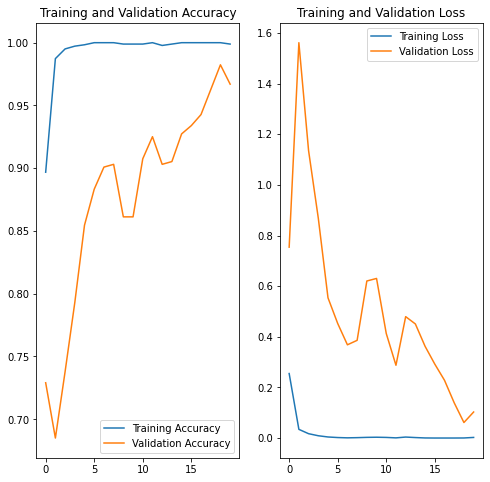

In [53]:
#@title Train history

acc = score.history['accuracy']
val_acc = score.history['val_accuracy']

loss = score.history['loss']
val_loss = score.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

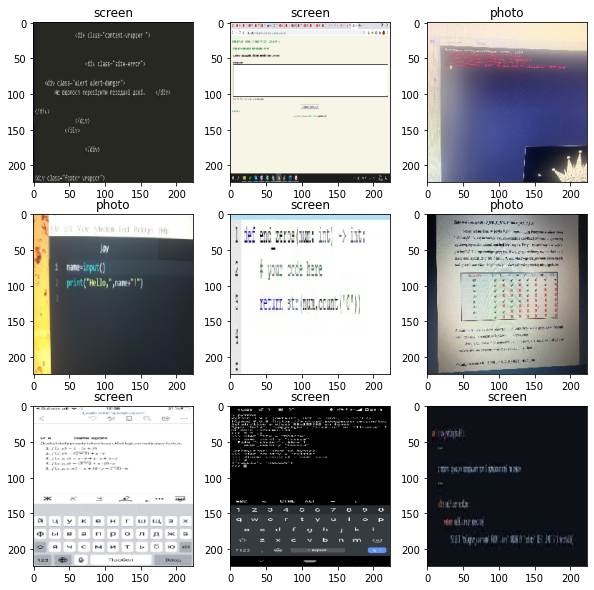

In [57]:
#@title Make 9 predictions
indexes = np.random.choice(len(test_x), 29)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = test_x[indexes[i]]
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 3)
    result = model.predict(img)
    class_label = "image" if result[0][0] > 0 else "photo"
    str_result = f"{class_label}"
    plt.title(str_result)
    plt.imshow((img.reshape(IMG_SIZE, IMG_SIZE, 3)).astype(np.uint8))

In [58]:
#@title Convert model

model_name = 'mobilenet2_image_photo_predictor_rgb_v1.0_224' #@param {type:"string"}

save_model = False #@param {type:"boolean"}
if save_model:
    print(f'Saving model to {drive_path}/{model_name}.h5')
    model.save(f'{drive_path}/{model_name}.h5')
    print(f'Saved')
  

save_tflite_model = True #@param {type:"boolean"}
if save_tflite_model:
    print(f'Saving model to {drive_path}/{model_name}.tflite')
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    with open(f'{drive_path}/{model_name}.tflite', 'wb') as f:
        f.write(tflite_model)
        print(f'Saved')

Saving model to /content/drive/MyDrive/mobilenet2_screen_photo_predictor_rgb_v1.0_224.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved
Saving model to /content/drive/MyDrive/mobilenet2_screen_photo_predictor_rgb_v1.0_224.tflite


INFO:tensorflow:Assets written to: /tmp/tmptwzyc2so/assets


INFO:tensorflow:Assets written to: /tmp/tmptwzyc2so/assets


Saved
